# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 5

**Author 1 (sciper):** Camillo Nicolò De Sabbata (335004)  
**Author 2 (sciper):** Gianluca Radi (334736)   
**Author 3 (sciper):** Alessandro Dalbesio (352298)   

**Release date:** 8.03.2023  
**Due date:** 24.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = './'
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Segmentation


### 1.0 Intro

In this exercise, you will be given two images. 

* `mucinous_adeno.jpg`: The image depicts a tissue sample from mucinous adenocarcinoma in colorectal cancer. The data is taken from the Cancer Genome Atlas (TCGA) which is an open-source database of different cancer types. Here you can see a tissue taken from a patient and stained using hematoxylin (purple) and eosin (pink) staining. The hematoxylin stains cell nuclei with a purplish blue, and the eosin stains the extracellular matrix and cytoplasm in pink.

* `mucinous_adeno_gt.jpg`: The second image is a coarse annotation of what is regarded as the so-called mucinous area. The mucinous area can be identified as a gray area tainted with purple. The presence of a large amount of mucin is a sign of a defect of normal epithelial cells that start to produce an unreasonable amount of mucin.


### 1.1 Tasks

You will be asked to extract the mucinous area using various approaches:

- [ ] Thresholding
- [ ] Morphology
- [ ] Region growing


### 1.1 Brain image visualization

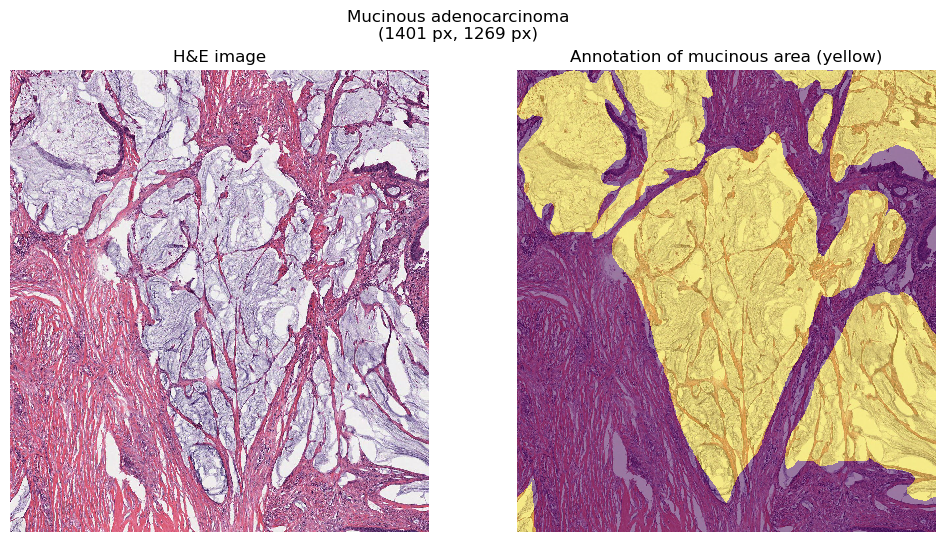

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load images
path_to_image = os.path.join(data_base_path, data_folder, "mucinous_adeno.jpg")
path_to_gt = os.path.join(data_base_path, data_folder, "mucinous_adeno_gt.jpg")
adeno_img = skimage.io.imread(path_to_image)
adeno_gt = skimage.io.imread(path_to_gt) > 128

# Get size of the image in px
im_h, im_w, im_c = adeno_img.shape

# Display MRI image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

# Plot image with overlay
ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')
plt.suptitle("Mucinous adenocarcinoma\n({} px, {} px)".format(im_h, im_w))
plt.show()

---
### 1.2 Thresholding (4pts)
#### 1.2.1 RGB & Hue (1 pts)

Display the histogram for each channel (R, G, and B) as well as the histogram for the H (hue) channel. Note that you can use [rgb2hsv](https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2hsv) to convert an RGB image to an HSV image and then extract the hue.

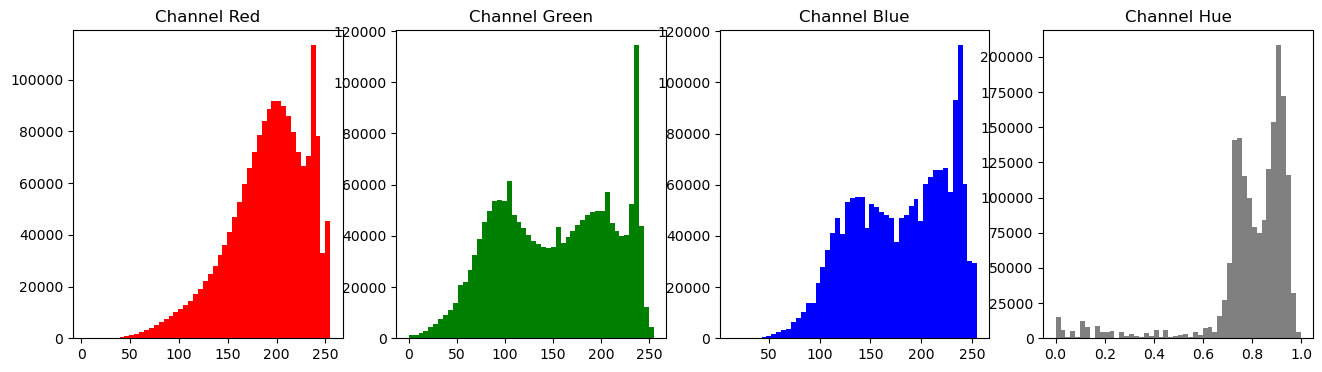

In [3]:
# Display the histograms of the image
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

# Red, Green and blue channels
channel_name = ['Red', 'Green', 'Blue']
for i in range(3):
    ax[i].hist(adeno_img[:, :, i].flatten(), bins=50, color=channel_name[i].lower())
    ax[i].set_title(f'Channel {channel_name[i]}')

# Hue channel
hsv_image = skimage.color.rgb2hsv(adeno_img) # Convert the image to HSV
ax[3].hist(hsv_image[:, :, 0].flatten(), bins=50, color='grey')
ax[3].set_title('Channel Hue')

# Show the plots
plt.suptitle('')
plt.show()

#### 1.2.2 Apply Thresholding (2 pts)

For each histogram find the threshold(s) that work the best to isolate the mucinous area. Display the image after thresholding of each channel as well as the error between your prediction ($im$) and the annotations ($gt$) using the formula:

$$error = 1 - \left( \frac{1}{IJ} \sum_{i,j} im_{i,j} == gt_{i, j} \right)$$

Here, I and J are the dimension of the image.

In [4]:
# Definition of the error_rate function
def error_rate(mask, gt):
    """Compute error rate between ground truth and prediction.
    
    Args:
        mask: predicted mask
        gt: ground truth mask

    Returns:
        error rate
    """
    return (mask != gt).mean()

In [5]:
from skimage import filters
from tabulate import tabulate
from colorama import Back, Fore, Style

# Compute threshold for each channel
channel_name = ['Red', 'Green', 'Blue', 'Hue'] # List of the channels we will test
threshold_names = ["Isodata", "Li", "Minimum", "Mean", "Triangle", "Yen", "Otsu"] # List of the methods we will test
best_thresholding_method_index = np.zeros(len(channel_name))   # Index of the best threshold method for each channel
best_thresholds = np.zeros(len(channel_name)) # Value of the best threshold for each channel
thresholds = np.zeros((len(channel_name), len(threshold_names))) # Threshold value for each channel and each method
for i in range(3):
    for j, threshold_name in enumerate(threshold_names):
        thresholds[i, j] = getattr(filters, "threshold_" + threshold_name.lower())(adeno_img[:, :, i])
for j, threshold_name in enumerate(threshold_names):
    thresholds[3, j] = getattr(filters,"threshold_" + threshold_name.lower())(hsv_image[:, :, 0])


# Display the table with the value of the threshold for each channel and method
tableElem = []
for i in range(len(channel_name)):
    temp = [channel_name[i]]
    for j in range(len(threshold_names)):
        temp.append(np.around(thresholds[i, j], 2))
    tableElem.append(temp)
print("Threshold values for each channel and method:")
print(tabulate(tableElem, ['']+threshold_names, tablefmt="pretty"))


# Compute error for each channel and method 
tableElem = []
for i in range(len(channel_name)):
    # Compute error for each threshold method for each channel
    tableElem.append([channel_name[i]])
    threshold_errors = np.zeros(len(threshold_names))
    for j in range(len(threshold_names)):
        threshold = thresholds[i, j]
        threshold_name = threshold_names[j]
        if i < 3:
            prediction = adeno_img[:, :, i] > threshold
        else:
            prediction = hsv_image[:, :, 0] < threshold
        # Compute error as the percentage of pixels that are not correctly classified
        error = error_rate(prediction, adeno_gt)
        threshold_errors[j] = error
        tableElem[i].append(np.around(error, 5))

    # Find the best threshold method and get its value
    best_thresholding_method_index[i] = np.argmin(threshold_errors)
    best_thresholds[i] = thresholds[i, int(best_thresholding_method_index[i])]


# Display the table with the error for each channel and method
print("\nErrors for each channel and threshold method:")
for i in range(len(tableElem)):
    for j in range(len(tableElem[i])):
        if j == best_thresholding_method_index[i]+1:
            tableElem[i][j] = Fore.BLACK + Back.WHITE + f"{tableElem[i][j]}" + Style.RESET_ALL
print(tabulate(tableElem, ['']+threshold_names, tablefmt="pretty"))
for i in range(len(channel_name)):
    print(f"Best threshold method for channel {channel_name[i]} is {threshold_names[int(best_thresholding_method_index[i])]}")
best_threshold_index = np.argmin(best_thresholds)
print(f"\nBest threshold overall is for channel {channel_name[best_threshold_index]} with method {threshold_names[int(best_thresholding_method_index[best_threshold_index])]}")

Threshold values for each channel and method:
+-------+---------+--------+---------+--------+----------+-------+-------+
|       | Isodata |   Li   | Minimum |  Mean  | Triangle |  Yen  | Otsu  |
+-------+---------+--------+---------+--------+----------+-------+-------+
|  Red  |  180.0  | 175.19 |  227.0  | 190.95 |  230.0   | 139.0 | 181.0 |
| Green |  149.0  | 139.75 |  147.0  | 151.9  |  227.0   | 144.0 | 150.0 |
| Blue  |  174.0  | 169.01 |  173.0  | 179.26 |  223.0   | 169.0 | 175.0 |
|  Hue  |  0.51   |  0.4   |  0.35   |  0.8   |   0.84   |  0.7  | 0.51  |
+-------+---------+--------+---------+--------+----------+-------+-------+

Errors for each channel and threshold method:
+-------+---------+---------+---------+---------+----------+---------+---------+
|       | Isodata |   Li    | Minimum |  Mean   | Triangle |   Yen   |  Otsu   |
+-------+---------+---------+---------+---------+----------+---------+---------+
|  Red  | 0.4511  | 0.45331 | 0.48417 | 0.4482  |  0.4897  | 0.4

Plot of the thresholded image and the histogram for each channel with the method that gives the lowest error:
 > Best threshold method for channel Red is Mean
 > Best threshold method for channel Green is Yen
 > Best threshold method for channel Blue is Otsu
 > Best threshold method for channel Hue is Triangle


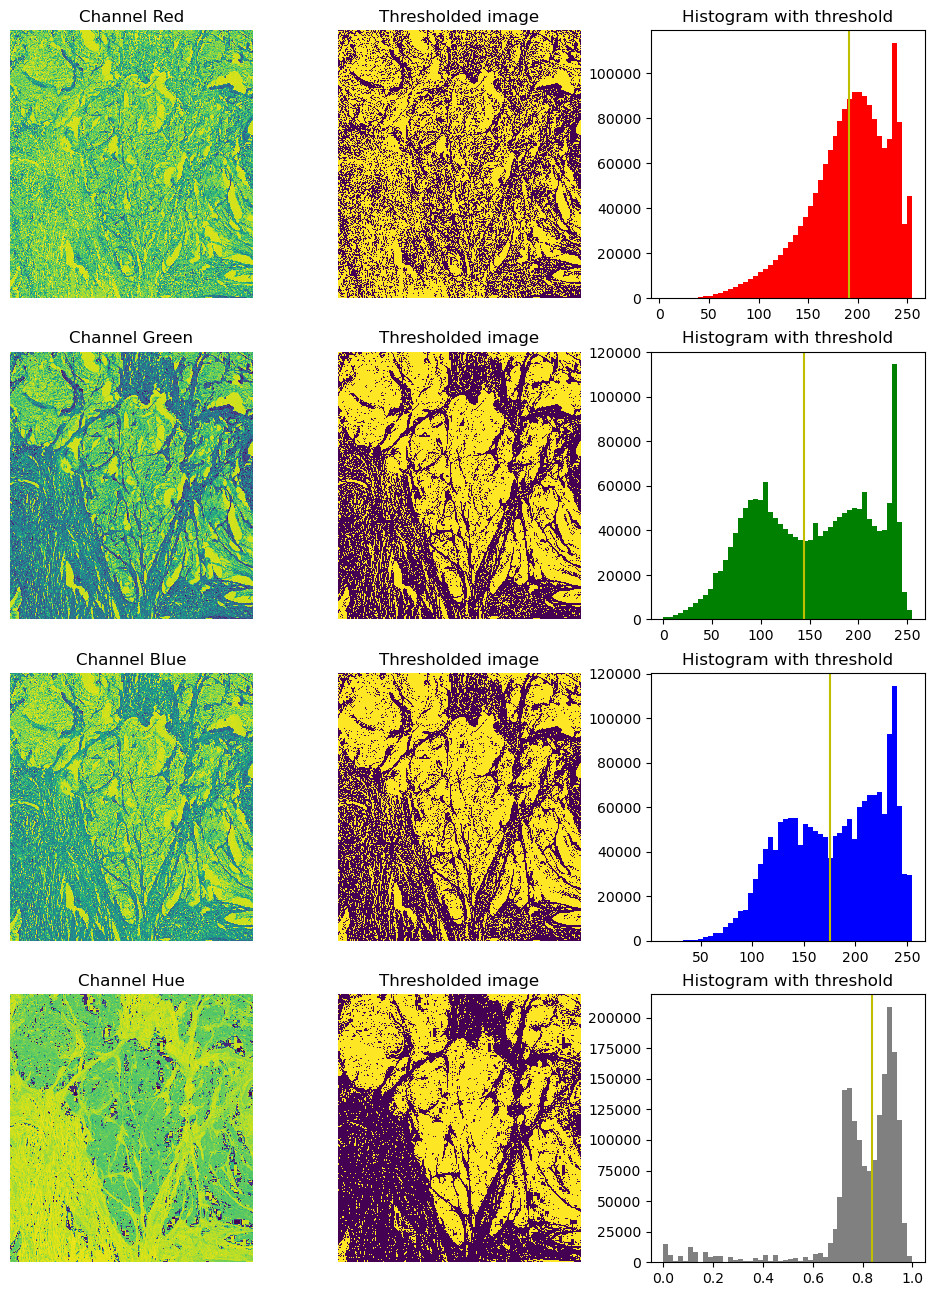

In [6]:
print("Plot of the thresholded image and the histogram for each channel with the method that gives the lowest error:")
for i in range(len(channel_name)):
    print(f" > Best threshold method for channel {channel_name[i]} is {threshold_names[int(best_thresholding_method_index[i])]}")
# Plot image, thresholded image and histogram for each channel with the method that gives the lowest error
fig, ax = plt.subplots(4, 3, figsize=(12, 16))

## Do the plotting for the RGB channels ##
for i in range(3):
    # Original image
    ax[i, 0].imshow(adeno_img[:, :, i], interpolation='nearest')
    ax[i, 0].set_title(f'Channel {channel_name[i]}')
    ax[i, 0].axis('off')

    # Thresholded image
    threshold = thresholds[i, int(best_thresholding_method_index[i])]
    prediction = adeno_img[:, :, i] > threshold
    ax[i, 1].imshow(adeno_img[:, :, i], interpolation='nearest')
    ax[i, 1].imshow(prediction, interpolation='nearest')
    ax[i, 1].set_title('Thresholded image')
    ax[i, 1].axis('off')
    
    # Histogram with threshold
    ax[i, 2].hist(adeno_img[:, :, i].flatten(), bins=50, color=channel_name[i].lower())
    ax[i, 2].axvline(threshold, color='y')
    ax[i, 2].set_title('Histogram with threshold')

## Do the plotting for the Hue channel ##
# Original image
ax[3, 0].imshow(hsv_image[:, :, 0], interpolation='nearest')
ax[3, 0].set_title(f'Channel {channel_name[3]}')
ax[3, 0].axis('off')

# Thresholded image
threshold = thresholds[3, int(best_thresholding_method_index[3])]
prediction = hsv_image[:, :, 0] < threshold
ax[3, 1].imshow(hsv_image[:, :, 0], interpolation='nearest')
ax[3, 1].imshow(prediction, interpolation='nearest')
ax[3, 1].set_title('Thresholded image')
ax[3, 1].axis('off')

# Histogram with threshold
ax[3, 2].hist(hsv_image[:, :, 0].flatten(), bins=50, color='grey')
ax[3, 2].axvline(threshold, color='y')
ax[3, 2].set_title('Histogram with threshold')

# Show the plots
plt.suptitle('')
plt.show()

#### 1.2.3 Best Thresholding (1 pts)

Based on your previous findings, set the best threshold(s) and create the final mask as the variable `mask_thesholding`

##### Final mask creation

In [7]:
mask_thesholding = hsv_image[:, :, 0] < thresholds[3, int(best_thresholding_method_index[3])]
mask_thesholding = mask_thesholding.astype(np.uint8)

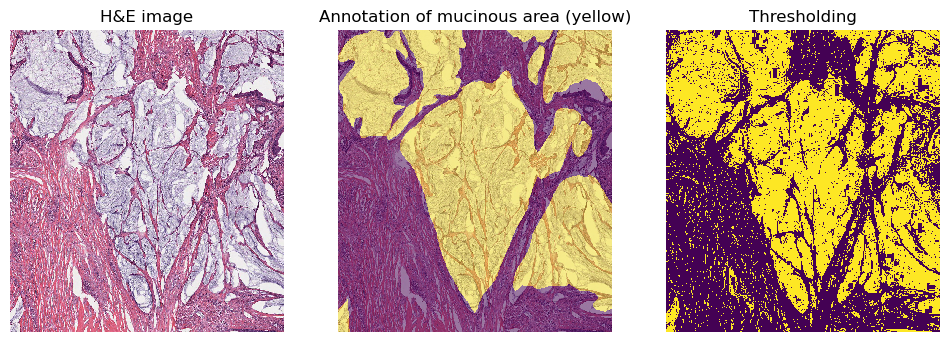

In [8]:
# Display MRI image
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')

ax[2].imshow(mask_thesholding, interpolation='nearest')
ax[2].imshow(mask_thesholding, alpha=0.5, interpolation='nearest')
ax[2].set_title('Thresholding')
ax[2].axis('off')

plt.show()

---

### 1.3 Morphology (5pts)

To proceed, use the best results of the previous model (namely `mask_thesholding`) as the starting point. In this exercise we will try to clean the mask using morphology.

* A (2pts): Try the following operation [closing](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.closing), [opening](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.opening) with [disk](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.disk) size of: $1, 2, 5, 10$. Comment on the quality of the results.

* B (2pts): Try the following operation [remove_small_holes](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_holes), [remove_small_objects](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_objects) with size of: $10, 50, 100, 500$. Comment on the quality of the results.

* C (1pts): Based on your previous results, can you find a combination of the functions that improve your results? Plot the best result along with the error rate. Save the mask as the variable `mask_morph`

##### Apply closing and then opening

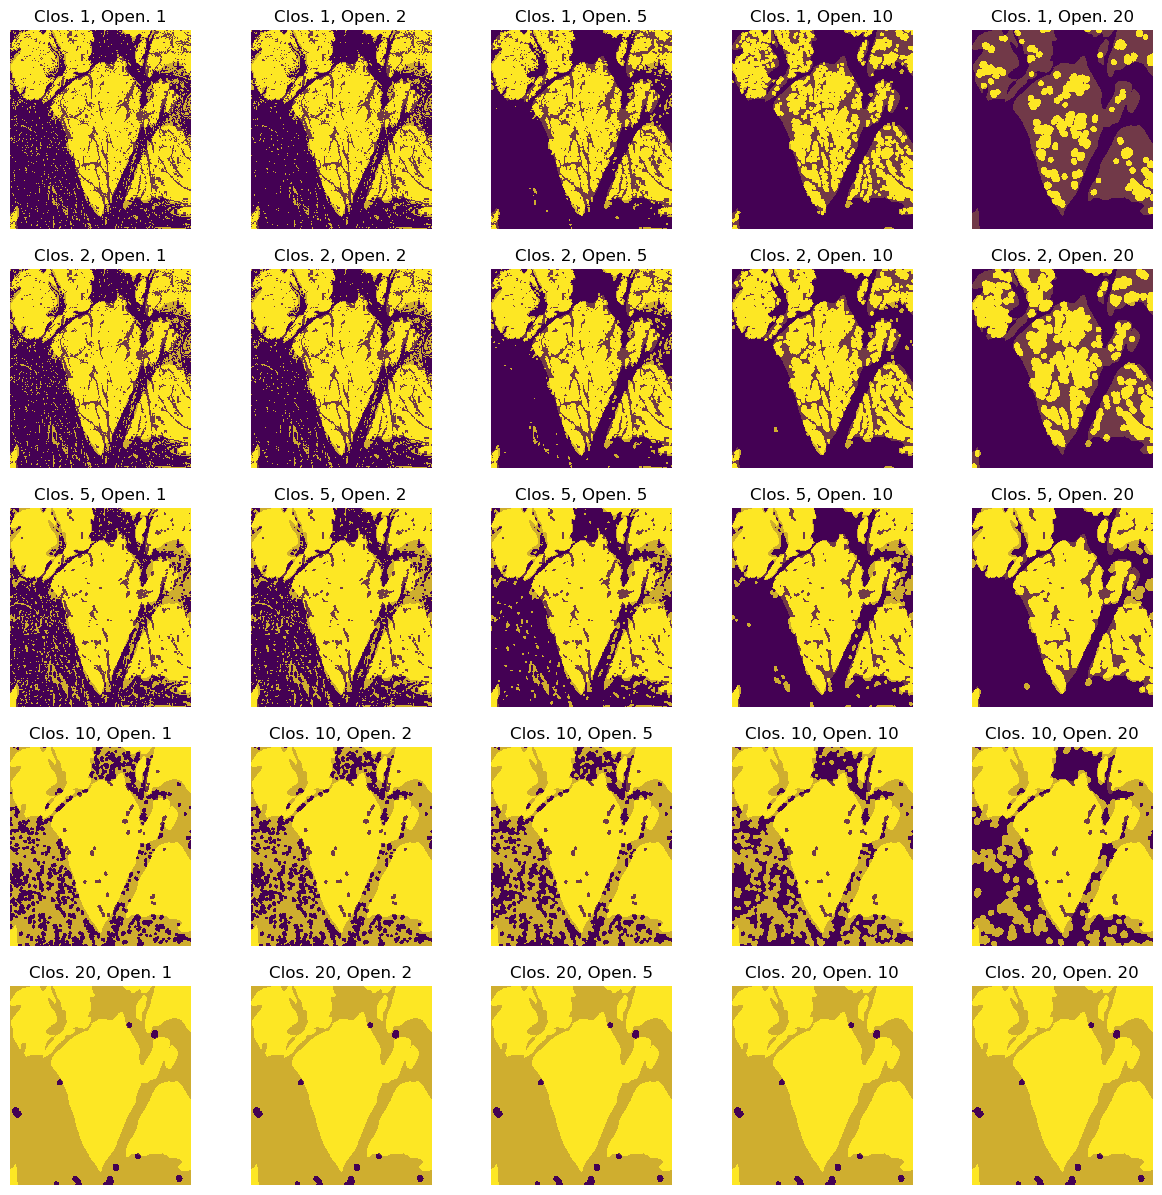

Errors for each combination of closing and opening:
+------------+-----------+-----------+-----------+------------+------------+
|            | Opening 1 | Opening 2 | Opening 5 | Opening 10 | Opening 20 |
+------------+-----------+-----------+-----------+------------+------------+
| Closing 1  |   0.182   |  0.1727   |   0.167   |   0.2086   |   0.3854   |
| Closing 2  |  0.1752   |  0.1665   |  0.1487   |   0.1514   |   0.2309   |
| Closing 5  |  0.1837   |   0.176   |  0.1514   |   0.1283   |   0.1193   |
| Closing 10 |  0.3108   |  0.3095   |  0.3023   |   0.2833   |   0.2302   |
| Closing 20 |  0.4584   |  0.4584   |  0.4584   |   0.4584   |   0.4583   |
+------------+-----------+-----------+-----------+------------+------------+


In [9]:
# Closing, opening and disk on the mask_thresholding
from skimage.morphology import disk, binary_closing, binary_opening
sizes = [1, 2, 5, 10, 20]
masks = []
errors = []

tableHeader = [''] + [f'Opening {opening_size}' for opening_size in sizes]
tableElem = []

for closing_size in sizes:
    temp = [f'Closing {closing_size}']
    for opening_size in sizes:
        mask = binary_closing(mask_thesholding, disk(closing_size))
        mask = binary_opening(mask, disk(opening_size))
        error = error_rate(mask, adeno_gt)
        errors.append(error)
        masks.append(mask)
        temp.append(np.around(error, 4))
    tableElem.append(temp)


# Display MRI image
fig, ax = plt.subplots(len(sizes), len(sizes), figsize=(15, 15))
for i in range(len(sizes)):
    for j in range(len(sizes)):
        ax[i, j].imshow(masks[i * len(sizes) + j], interpolation='nearest')
        ax[i, j].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
        ax[i, j].set_title(f'Clos. {sizes[i]}, Open. {sizes[j]}')
        ax[i, j].axis('off')
plt.show()

print("Errors for each combination of closing and opening:")
print(tabulate(tableElem, tableHeader, tablefmt="pretty"))


##### Remove small holes and then remove small objects

C:\Users\gianl\anaconda3\lib\site-packages\skimage\_shared\utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


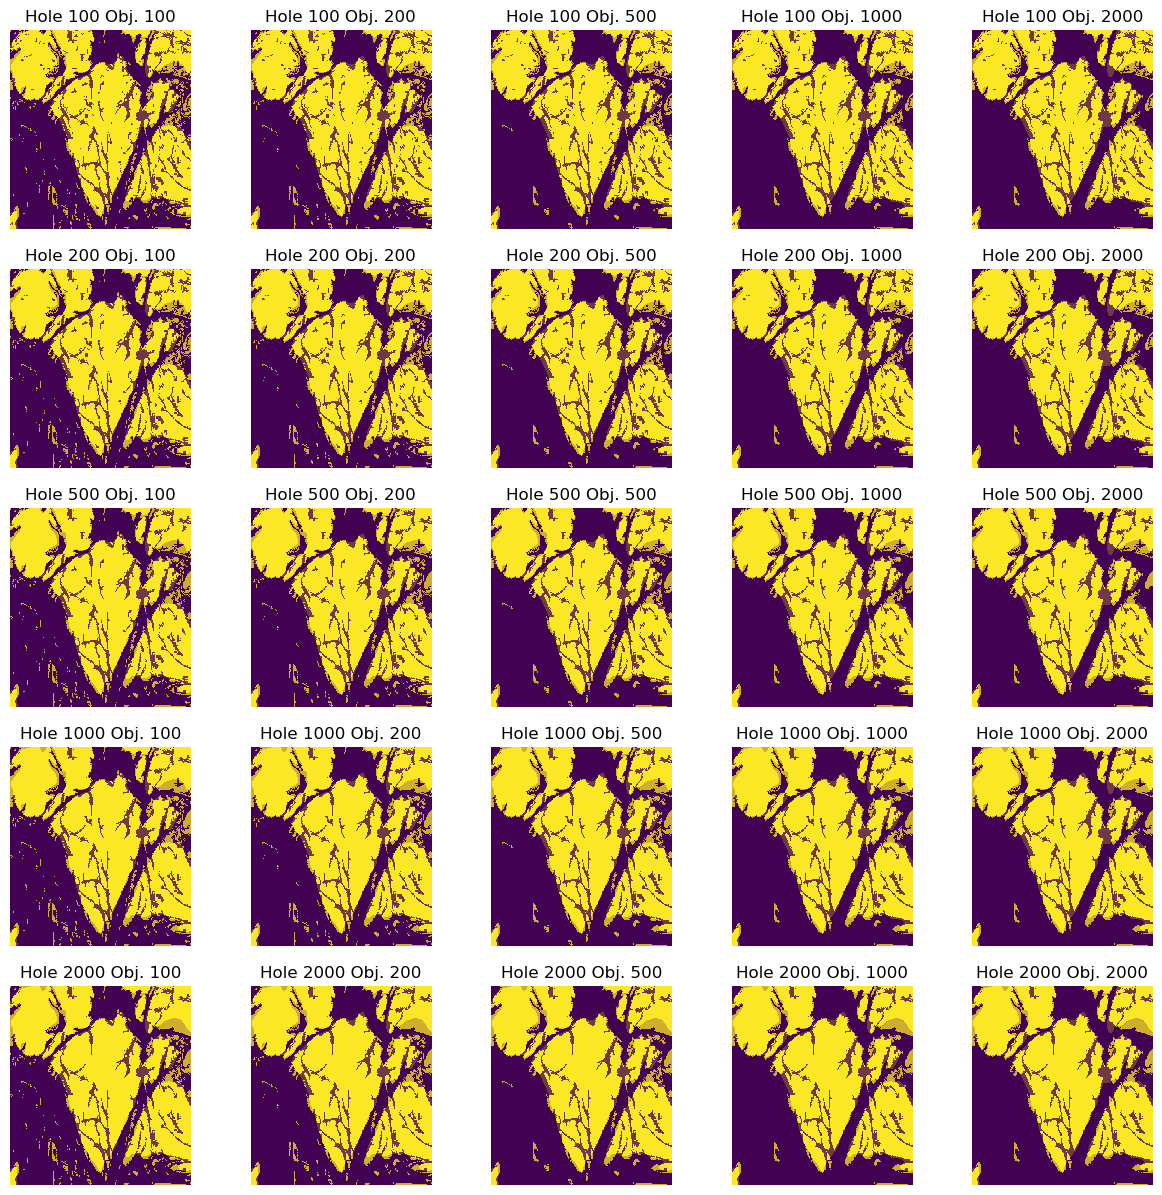

Errors for each combination of remove small holes and remove small objects:
+------------------+-------------------+-------------------+-------------------+--------------------+--------------------+
|                  | Small objects 100 | Small objects 200 | Small objects 500 | Small objects 1000 | Small objects 2000 |
+------------------+-------------------+-------------------+-------------------+--------------------+--------------------+
| Small holes 100  |      0.1576       |      0.1532       |      0.1469       |       0.1415       |       0.1388       |
| Small holes 200  |      0.1531       |      0.1486       |      0.1422       |       0.1371       |       0.134        |
| Small holes 500  |      0.1499       |      0.1454       |       0.139       |       0.1339       |       0.1308       |
| Small holes 1000 |      0.1483       |      0.1438       |      0.1383       |       0.1333       |       0.1307       |
| Small holes 2000 |      0.1471       |      0.1426       |   

In [10]:
# remove_small_holes, remove_small_objects on the mask_thresholding
from skimage.morphology import remove_small_holes, remove_small_objects
sizes = [100, 200, 500, 1000, 2000]
masks = []
errors = []

tableHeader = [''] + [f'Small objects {size}' for size in sizes]
tableElem = []

for hole_size in sizes:
    temp = [f'Small holes {hole_size}']
    for object_size in sizes:
        mask = remove_small_holes(mask_thesholding, hole_size)
        mask = remove_small_objects(mask, object_size)
        error = error_rate(mask, adeno_gt)
        errors.append(error)
        masks.append(mask)
        temp.append(np.around(error, 4))
    tableElem.append(temp)

# Display MRI image
fig, ax = plt.subplots(len(sizes), len(sizes), figsize=(15, 15))
for i in range(len(sizes)):
    for j in range(len(sizes)):
        ax[i, j].imshow(masks[i * len(sizes) + j], interpolation='nearest')
        ax[i, j].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
        ax[i, j].set_title(f'Hole {sizes[i]} Obj. {sizes[j]}')
        ax[i, j].axis('off')
plt.show()

print("Errors for each combination of remove small holes and remove small objects:")
print(tabulate(tableElem, tableHeader, tablefmt="pretty"))

##### Test various combinations of morphology operations

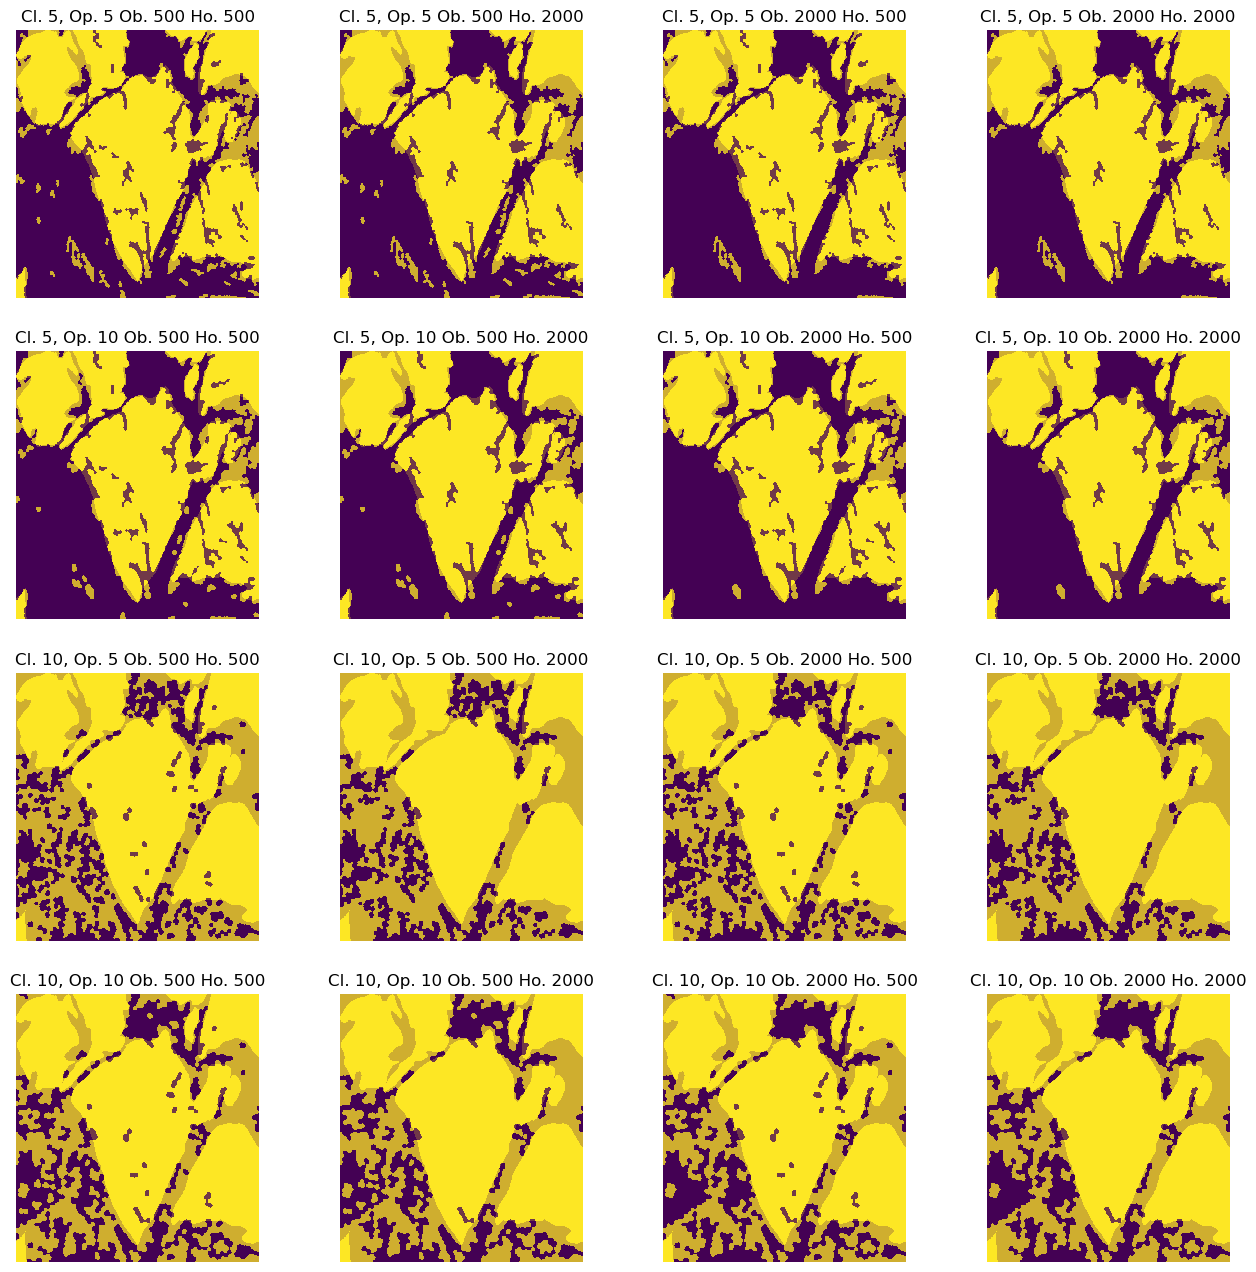

Errors for each combination of closing, opening, remove small holes and remove small objects:
+---------------+-----------------+------------------+------------------+-------------------+
|               | Ob. 500 Ho. 500 | Ob. 500 Ho. 2000 | Ob. 2000 Ho. 500 | Ob. 2000 Ho. 2000 |
+---------------+-----------------+------------------+------------------+-------------------+
|  Cl. 5 Op. 5  |     0.1376      |      0.1314      |      0.1256      |      0.1195       |
| Cl. 5 Op. 10  |     0.1225      |      0.1185      |      0.1137      |      0.1097       |
| Cl. 10 Op. 5  |     0.3043      |      0.3154      |      0.3016      |      0.3126       |
| Cl. 10 Op. 10 |     0.2841      |      0.2849      |      0.2763      |      0.2771       |
+---------------+-----------------+------------------+------------------+-------------------+


In [11]:
# Apply remove_small_holes, remove_small_objects on the mask closed and opened
from itertools import product
opening_closing_sizes = [5, 10]
hole_object_sizes = [500, 2000]
masks = []
errors = []

# Header containing the different Object and Hole sizes
tableHeader = [''] + ['Ob. ' + str(obj_size) + ' Ho. ' + str(hole_size) for obj_size, hole_size in product(hole_object_sizes, hole_object_sizes)]
tableElem = []

for closing_size, opening_size in product(opening_closing_sizes, opening_closing_sizes):
    temp = ['Cl. ' + str(closing_size) + ' Op. ' + str(opening_size)]
    masks.append([])
    for object_size, hole_size in product(hole_object_sizes, hole_object_sizes):
        mask = binary_closing(mask_thesholding, disk(closing_size))
        mask = binary_opening(mask, disk(opening_size))
        mask = remove_small_holes(mask, hole_size)
        mask = remove_small_objects(mask, object_size)
        error = error_rate(mask, adeno_gt)
        errors.append(error)
        masks[-1].append(mask)
        temp.append(np.around(error, 4))
    tableElem.append(temp)

# Display MRI image
fig, ax = plt.subplots(len(opening_closing_sizes)*2, len(opening_closing_sizes)*2, figsize=(16, 16))
for i, j in product(range(len(opening_closing_sizes)), range(len(opening_closing_sizes))):
    for k, l in product(range(len(hole_object_sizes)), range(len(hole_object_sizes))):
        row = i*2+j
        col = k*2+l
        ax[row, col].imshow(masks[row][col], interpolation='nearest')
        ax[row, col].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
        ax[row, col].set_title(f'Cl. {opening_closing_sizes[i]}, Op. {opening_closing_sizes[j]} Ob. {hole_object_sizes[k]} Ho. {hole_object_sizes[l]}')
        ax[row, col].axis('off')
plt.show()

print("Errors for each combination of closing, opening, remove small holes and remove small objects:")
print(tabulate(tableElem, tableHeader, tablefmt="pretty"))

We obtain the best results for:
- Closing size 5
- Opening size 10
- Object size 1000
- Hole size 1000

Using a middle-value for the disk size in the closing and opening operations yields the best result.
Instead, higher values for the the disk size in the removing of small objects and holes perform better.

In [12]:
mask_morph = masks[np.argmin(errors)//4][np.argmin(errors)%4]

---
### 1.4 Region growing (5pts)

In this exercise you will implement from scratch your own region growing algorithm. Choose one of the image channel (R/G/B/H) as the source image. You can use multiple seed point to achieve better results. Plot the best result along with the error rate. Save the mask as the variable `mask_region`.

Since the region results of the region growing algorithm depends on the selection of the seed points (which is a randomic choice) we apply the region growing algorithm multiple times with multiple tolerance thresholds (the tolerance thresholds are the same between the different experiments). <br>
We will then plot then plot the mean values with the variance and we will choose the best method based on the mean values of the errors (the mean value it's an estimation of the true value for the central limit theorem)

In [13]:
from skimage.segmentation import flood

# Get the hue channel from the hsv image
hue_image = hsv_image[:, :, 0]

# Get random seeds (we select 100 random seeds). We use the ground truth image to select the possible seeds points.
seeds = np.array(np.where(adeno_gt == 0)).T 
tolerance_thresholds = [x/100 for x in range(1, 10)]
errors = [] 
masks = []
NUM_ITERATIONS = 5

# Compute region growing
for i in range(NUM_ITERATIONS):
    random_seeds = seeds[np.random.choice(seeds.shape[0], 100, replace=False), :] # Generate 100 random seeds
    errors.append([])
    masks.append([])
    for tolerance in tolerance_thresholds:
        mask = np.ones_like(hue_image)
        for seed in random_seeds:
            new_mask = flood(hue_image, (seed[0], seed[1]), tolerance=tolerance)
            mask = np.logical_and(mask, np.logical_not(new_mask).astype(int))
        errors[i].append(error_rate(mask, adeno_gt))
        masks[i].append(mask)

errors = np.array(errors).T
masks = np.array(masks)

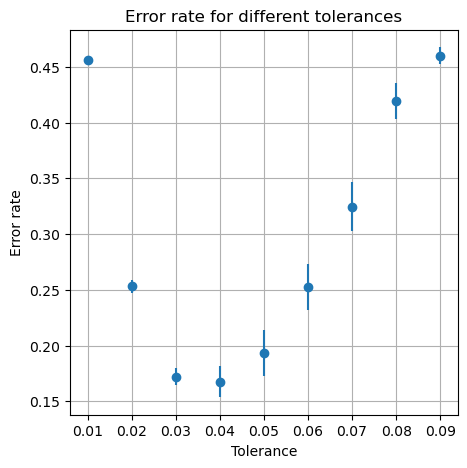

Mean and standard deviation for each tolerance with 5 experiments:
+-----------+------------+-----------+----------------+
| Tolerance | Mean Error | Std Error | Smallest Error |
+-----------+------------+-----------+----------------+
|   0.01    |   0.456    |  0.0032   |     0.4505     |
|   0.02    |   0.2532   |  0.0056   |     0.2461     |
|   0.03    |   0.172    |  0.0076   |     0.1647     |
|   0.04    |   0.1676   |  0.0138   |     0.1488     |
|   0.05    |   0.1934   |   0.021   |     0.1706     |
|   0.06    |   0.2524   |  0.0204   |     0.2288     |
|   0.07    |   0.3244   |  0.0219   |     0.2915     |
|   0.08    |   0.4193   |  0.0162   |     0.3894     |
|   0.09    |   0.4599   |  0.0076   |     0.4509     |
+-----------+------------+-----------+----------------+
Best mask for each tolerance:


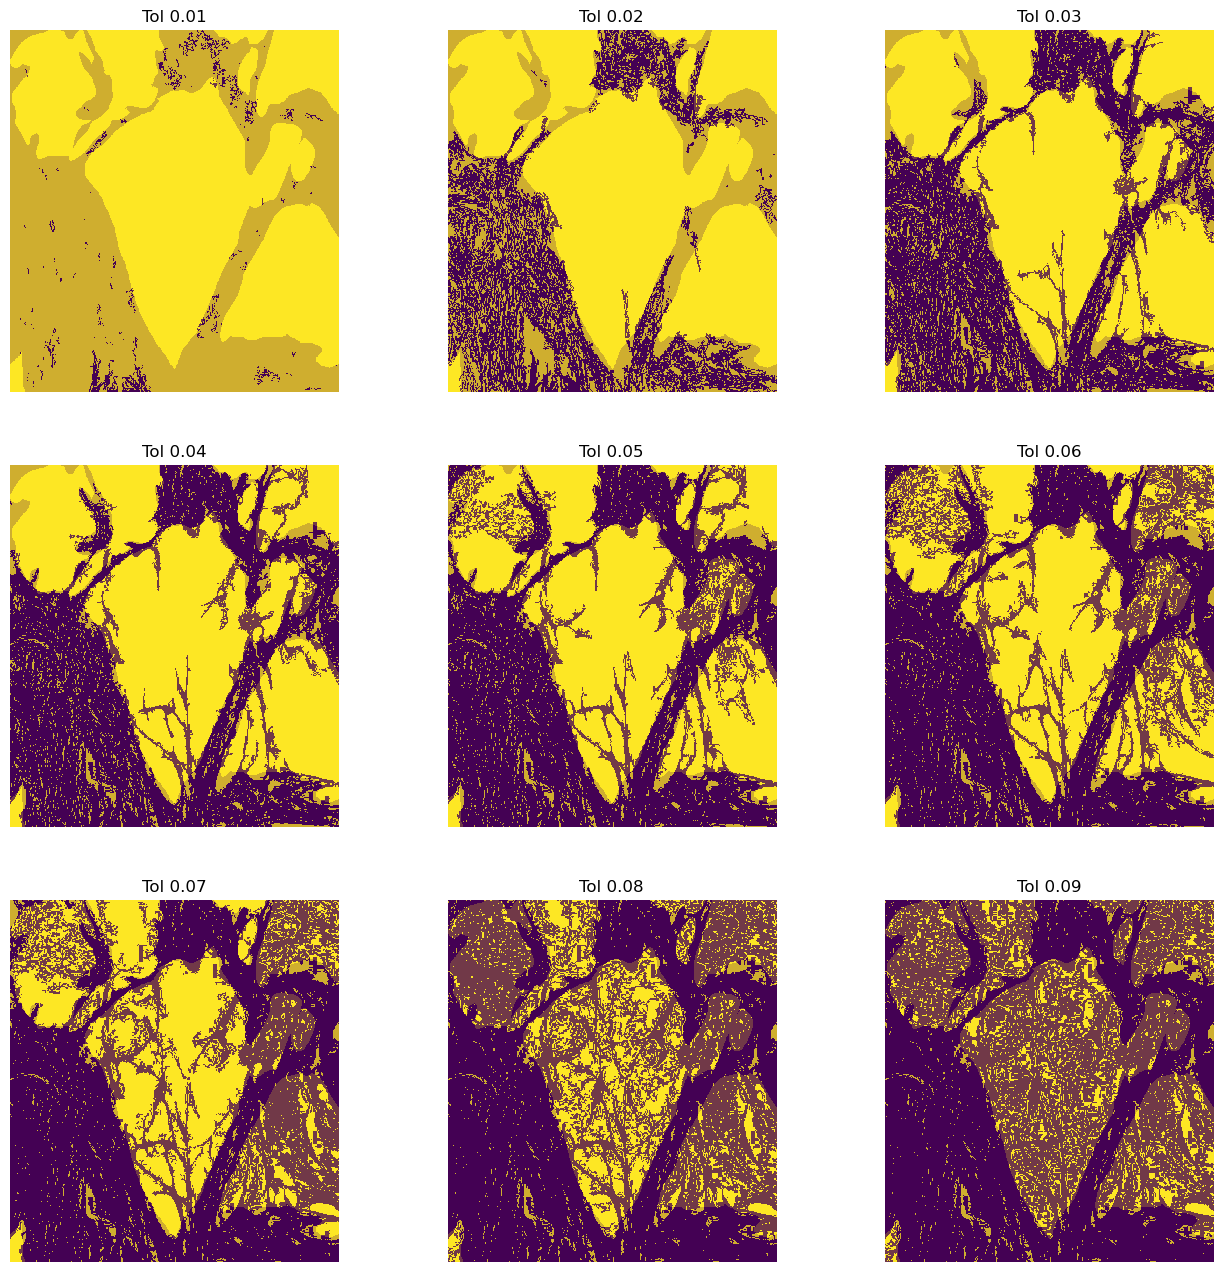

In [14]:
means = [np.mean(x) for x in errors]
stds = [np.std(x) for x in errors]

# Plot the mean with the standard deviation
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.errorbar(tolerance_thresholds, [np.mean(x) for x in errors], yerr=[np.std(x) for x in errors], fmt='o', ls='none')
ax.set_xlabel('Tolerance')
ax.set_ylabel('Error rate')
ax.set_title('Error rate for different tolerances')
plt.grid()
plt.show()

# Print the mean and standard deviation for each tolerance
tableHeader = ['Tolerance', 'Mean Error', 'Std Error', 'Smallest Error']
tableElem = []
for i in range(len(tolerance_thresholds)):
    tableElem.append([tolerance_thresholds[i], np.around(means[i], 4), np.around(stds[i], 4), np.around(np.min(errors[i]), 4)])
print(f"Mean and standard deviation for each tolerance with {NUM_ITERATIONS} experiments:")
print(tabulate(tableElem, tableHeader, tablefmt="pretty"))

# Plot the best mask for each tolerance
best_masks_for_each_tolerance = [masks[np.argmin(errors[i])][i] for i in range(len(tolerance_thresholds))]

print("Best mask for each tolerance:")
fig, ax = plt.subplots(3, 3, figsize=(16, 16))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(best_masks_for_each_tolerance[i * 3 + j], interpolation='nearest')
        ax[i, j].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
        ax[i, j].set_title(f'Tol {tolerance_thresholds[i * 3 + j]}')
        ax[i, j].axis('off')
plt.show()

In [15]:
# Get the best mask
mask_region = best_masks_for_each_tolerance[np.argmin([error_rate(x, adeno_gt) for x in best_masks_for_each_tolerance])]

---
### 1.5 Method comparison (1pt)

In this section we display the overall outputs. Please make sure that you create the variables `mask_thesholding`, `mask_morph`, and `mask_region` to properly display the output. Comment on the results and what you think would be the best approach.

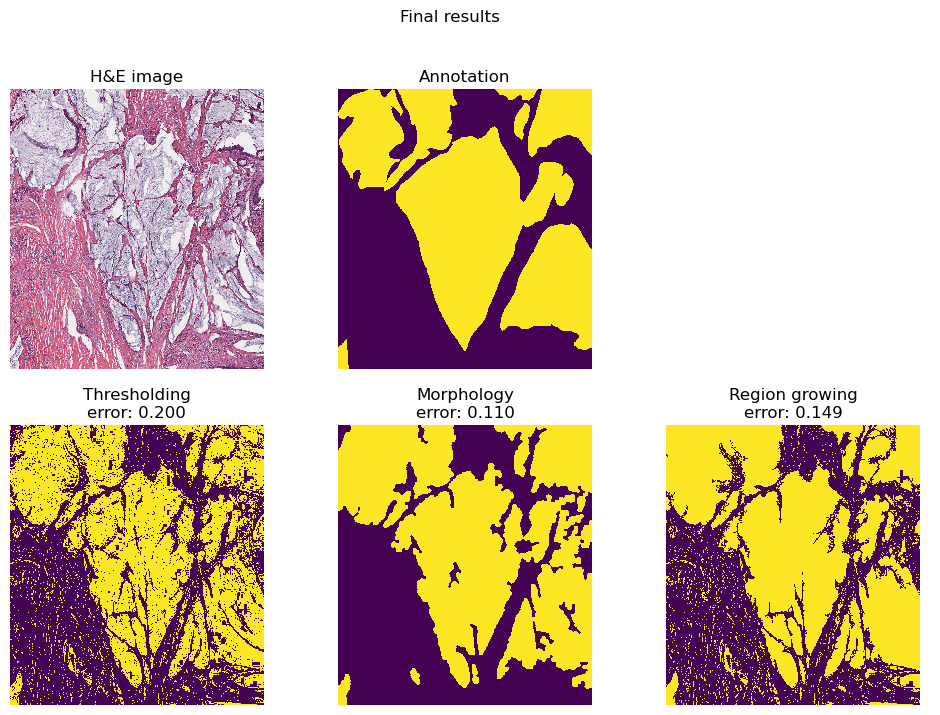

In [16]:
error_th = 1- (mask_thesholding == adeno_gt).mean()
error_morph = 1- (mask_morph == adeno_gt).mean()
error_region = 1- (mask_region == adeno_gt).mean()


# Display MRI image
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Plot image
ax[0, 0].imshow(adeno_img, interpolation='nearest')
ax[0, 0].set_title('H&E image'.format(im_h, im_w))

# Plot image with overlay
ax[0, 1].imshow(adeno_gt, interpolation='nearest')
ax[0, 1].set_title('Annotation')

# Plot estimation using thresholding
ax[1, 0].imshow(mask_thesholding, interpolation='nearest')
ax[1, 0].set_title('Thresholding\nerror: {:.3f}'.format(error_th))

# Plot estimation using Contour detection
ax[1, 1].imshow(mask_morph, interpolation='nearest')
ax[1, 1].set_title('Morphology\nerror: {:.3f}'.format(error_morph))


# Plot estimation using Region growing
ax[1, 2].imshow(mask_region, interpolation='nearest')
ax[1, 2].set_title('Region growing\nerror: {:.3f}'.format(error_region))


[a.axis('off') for a in ax.ravel()]


plt.suptitle("Final results")
plt.show()

## Comments
For now, the lowest error is achieved with morphology applied on thresholding. However, the region growing mask achieves better results than the thresholding one, therefore we could try applying morphology techniques on region growing mask. In the end, the results obtained using the region growing mask and morphology techniques are the best ones.

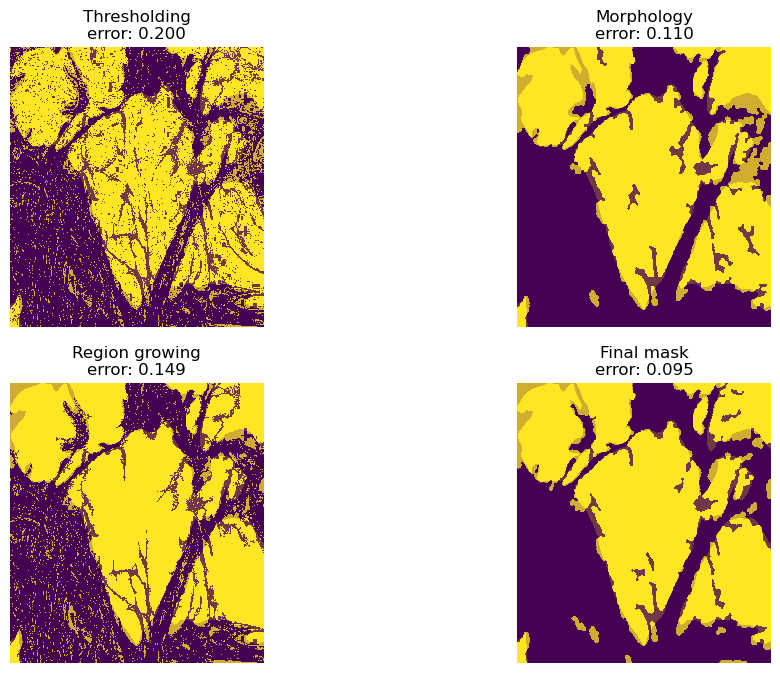

In [17]:
mask = binary_closing(mask_region, disk(5))
mask = binary_opening(mask, disk(10))
mask = remove_small_holes(mask, 1000)
mask = remove_small_objects(mask, 1000)
error = error_rate(mask, adeno_gt)
# Display MRI image of mask thresholding, morphology, region growing and final mask
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0, 0].imshow(mask_thesholding, interpolation='nearest')
ax[0, 0].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
ax[0, 0].set_title('Thresholding\nerror: {:.3f}'.format(error_th))
ax[0, 0].axis('off')
ax[0, 1].imshow(mask_morph, interpolation='nearest')
ax[0, 1].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
ax[0, 1].set_title('Morphology\nerror: {:.3f}'.format(error_morph))
ax[0, 1].axis('off')
ax[1, 0].imshow(mask_region, interpolation='nearest')
ax[1, 0].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
ax[1, 0].set_title('Region growing\nerror: {:.3f}'.format(error_region))
ax[1, 0].axis('off')
ax[1, 1].imshow(mask, interpolation='nearest')
ax[1, 1].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
ax[1, 1].set_title('Final mask\nerror: {:.3f}'.format(error))
ax[1, 1].axis('off')
plt.show()


## Part 2: Axon segmentations (10 points)

#### Intro 

Axon segmentation is vital to neuroscience research as it enables the study of neurons' morphology and connectivity. We will conduct two exercises to evaluate the impact of your segmentation algorithms under different independent artefacts. Each exercise consists of a synthetic **Ground Truth (GT)** and two more images simulating a specific artifact.

The **Ground Truth**  has tree main compartments. 1) The inner part of the axon. 2) The outer layer of the axon (called myelin) and the extracellular slace (the background of the image). 

The task consists into segmenting the three main compartments in the image to compute the inner-axon and outer-axon radii distribution.


To compute the radii, we suggest the following approximation.
$$\hat{r}_{I}= \sqrt{\frac{A_{yellow}}{\pi}}$$
$$\hat{r}_{O}= \sqrt{\frac{A_{yellow} + A_{blue}}{\pi}}$$
Where **A** is the corresponding area of the comparments. <br><br>
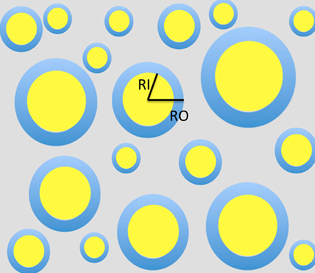

#### Artifacts simulated:

Excercise 1) Two images with different levels of SNR (signal to noise ratio). The images have rician noise.
Exercise  2) Two images adquired using a fraction of the fourier space. Only Lowest frequency are used to reconstruct the image. (simulating fast aquisitions in MRI)

Ensure your algorithm works on the GT before you go to the test cases with artifacts. Apply any preprocessing needed to the image. The preprocessing can be different for each type of image.

### Tasks

For each exercise we ask to:

1) Segment the images with the following colors: blue the inner part of the axon, red the outer part of the axon (myelin) and white for the backround(example) 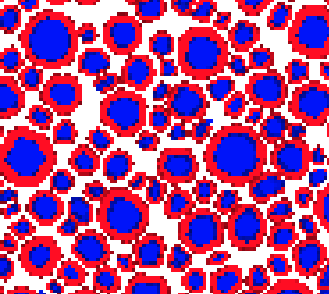

2) Count the number of axons obtained in the sample, calculate the radii for each axons, and display a radii histogram for the each of the images(GT and test cases).

In the exercises, assume that each pixel side is $(0.1 \mu m)$, i.e. a pixel has an area of $(0.01 \mu m^2 )$

## Grading 
The answers does not have to be perfect, they just be a good approximation.

1. Developing an algorithm that works for the two GT images. **(3 points)** 
2. Use preprosesing to prepare the images with SNR and the Low frequencies.  (**1 point** for SNR preprocesing , **1 point** for Low-frequency images preprocesing)
3. Running the algorithm in the test images. **1/2 point** SNR, **1/2 point** Low freqs
4. Computing and plotting radii distributions **(1 point)**
5. Explaining and discussing your implementation. **(3 points )**
    Try to be specific, not necessarily long. In the discussion include:
 1. What worked? 
 2. What did not work?
 3. Why do you think it does not work? 
 4. How could you improve your algorithms as future work?  Try to avoid general comments like "using deep learning" 
 
**Extra points: Real data example (3 points), the algorithm should display a _good enough_ segmentation.**

### 2.0 Global functions
Here we define few functions that we will use in the various sections

In [18]:
from skimage.filters import threshold_multiotsu

def segmentImage(img, n_classes):
    thresholds = threshold_multiotsu(img[:, :, 0], classes=n_classes)
    regions = np.digitize(img, bins=thresholds, right=True) # The parameter right=True is needed since the GT image is composed by only three colors
    length = len(regions)
    color_map = {0: np.array([255, 0, 0]), 1: np.array([0, 0, 255]), 2: np.array([255, 255, 255])}
    for i in range(length):
        for j in range(length):
            regions[i,j] = color_map[regions[i,j,0]]
    return regions

def computeRadii(img):
    inner = img[:,:,0]
    outer = img[:,:,1] + inner
    outer[outer == 255] = 0
    outer[outer > 255] = 255
    inner_radii = []
    outer_radii = []
    inner_visited = np.zeros((1024,1024))
    outer_visited = np.zeros((1024,1024))
    for i in range(1024):
        for j in range(1024):
            if inner[i,j] == 0 and inner_visited[i,j] == 0:
                # Flood from the current point
                flood_mask = flood(inner, (i,j))
                inner_visited += flood_mask
                # Compute the radius of the current nucleus
                radius = np.sum(flood_mask) / np.pi
                if radius > 10:
                    inner_radii.append(radius)
            if outer[i,j] == 0 and outer_visited[i,j] == 0:
                # Flood from the current point
                flood_mask = flood(outer, (i,j))
                outer_visited += flood_mask
                # Compute the radius of the current nucleus
                radius = np.sum(flood_mask) / np.pi
                if radius > 10:
                    outer_radii.append(radius)
    
    return [np.array(inner_radii), np.array(outer_radii)]

### 2.1 SNR

In [19]:
import cv2
import matplotlib.pyplot as plt

data_base_path = ''
data_folder = 'lab-01-data'

path_folder = os.path.join(data_base_path, data_folder) + '/' 

files = ["GT_0.png"  , "test_0_0.png" , "test_0_1.png"]
gt_0 = cv2.imread(path_folder+ files[0])
snr_10 = cv2.imread(path_folder+ files[1])
snr_3 = cv2.imread(path_folder+ files[2])

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

ModuleNotFoundError: No module named 'cv2'

### 2.1.1 Preprocessing 
In the preprocessing of our images we have choosen to apply restoration methods that reduce the variance in our images which is increased by the noise. <br>
We have choosen to avoid too simple filters due to the problems related to contourn smoothing. We don't want to smooth our contourns since we need them to be able to compute the axon's radii. <br>
We have choosen to apply a total variation denoising filter which is able to reduce the noise while at the same time preserving the edges. With the choosen filter we are able to obtain good results while at the same time preserving the edges (as we wanted).

In [ ]:
# Denoise with total variation
from skimage.restoration import denoise_tv_chambolle

# Denoise with total variation
snr_10_preprocessed = denoise_tv_chambolle(snr_10, weight=0.1, channel_axis=-1)
snr_3_preprocessed = denoise_tv_chambolle(snr_3, weight=0.2, channel_axis=-1)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(24, 12))
for ax, im, nm in zip(axes.ravel(), [gt_0, snr_10_preprocessed, snr_3_preprocessed], im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()


### 2.1.2 Results Segmetations

Thanks to the preprocessed images we are here able to obtain very good results in the segmentations of the images.<br>
We can see that in both SNR3 and SNR10 we are able to obtain results very close to the ones achieved with the GT images. 

In [ ]:
gt_0_seg = segmentImage(gt_0, 3)
snr_3_seg = segmentImage(snr_3_preprocessed, 3)
snr_10_seg = segmentImage(snr_10_preprocessed, 3)


fig, axes = plt.subplots(1, 2, figsize=(8, 8))
for ax, im, nm in zip(axes.ravel(), [gt_0, gt_0_seg], ['Original GT', 'Segmented GT']):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
for ax, im, nm in zip(axes.ravel(), [snr_10, snr_10_seg], ['Original SNR 10', 'Segmented SNR 10']):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
for ax, im, nm in zip(axes.ravel(), [snr_3, snr_3_seg], ['Original SNR 3', 'Segmented SNR 3']):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()


### 2.1.3 Radii histrograms 

In [ ]:
## results Radii distribution. proposal feel free to change it
import numpy as np

rads_gt = computeRadii(gt_0_seg)
print("FIRST DONE")
rads_test0 = computeRadii(snr_10_seg)
print("SECOND DONE")
rads_test1 = computeRadii(snr_3_seg)

all_rads= [rads_gt , rads_test0 , rads_test1] 

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, rads, nm in zip(axes.ravel(), all_rads, im_names):
    ax.hist(rads[0]  , color = "red" , label = "inner" ,alpha= 0.5)
    ax.hist(rads[1]  , color = "blue" , label = "outer" ,alpha= 0.5)
    ax.legend()
    ax.set_title(nm)
plt.show()


### 2.2 Low frequencies

In [ ]:

files = ["GT_3.png"  , "test_3_0.png" , "test_3_1.png"]
path = "data/"
gt_3 = cv2.imread(path_folder+ files[0])
lowfreq0 = cv2.imread(path_folder+ files[1])
lowfreq1 = cv2.imread(path_folder+ files[2])

images = [gt_3 , lowfreq0, lowfreq1]
im_names = ["GT" , "Low " , "Lower"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2.1 Preprocessing

In this case, the high frequencies of our images has been filtered out and as a result we have smoother contourn. <br>
In this case, we would like to enhance our contourns to be able to compute the axon's raddis.<br>
We have tested three different approaches:
1. unsharp_mask method: In this case we have applied this technique which sharpens the image. <br>
In this case, we saw that by appling this method we lose our information related to the internal part of the axons. As a consequence we have choosen to apply the unsharp_mask method, compute where the contourns were (by computing a threshold value) and enhance them in the original image. Thanks to this we were able to enhance the contourn and at the same time keep the original informations.
2. Sobel method: In this case, we have applied this technique to identify where the contourns were. Then we have applied a method very similar to the one used in the first approach.
3. Thresholding: In this case we have applied a technique similar to the first one but without the unsharp_mask method to see if it was able to add more information.

##### Preprocessing using the unsharp_mask method

In [ ]:
# Apply unsharp mask
from skimage.filters import unsharp_mask, threshold_otsu, median

# Apply unsharp mask
lowfreq0_mask = unsharp_mask(lowfreq0, radius=5, amount=2, channel_axis=0)[...,0]
lowfreq1_mask = unsharp_mask(lowfreq1, radius=25, amount=1.5, channel_axis=0)[...,0]

# Find a threshold to segment the image
lowfreq0_region = lowfreq0_mask < threshold_otsu(lowfreq0_mask)
lowfreq1_region = lowfreq1_mask < threshold_otsu(lowfreq1_mask)

# Copy the original image and set the pixels identified with lowfreq0_region to black
lowfreq0_preprocessed_unsharp = lowfreq0.copy()
lowfreq1_preprocessed_unsharp = lowfreq1.copy()
lowfreq0_preprocessed_unsharp[lowfreq0_region] = [0,0,0]
lowfreq1_preprocessed_unsharp[lowfreq1_region] = [0,0,0]

# Apply a median filter to remove noise
lowfreq0_preprocessed_unsharp = median(lowfreq0_preprocessed_unsharp)
lowfreq1_preprocessed_unsharp = median(lowfreq1_preprocessed_unsharp)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), [gt_3, lowfreq0_preprocessed_unsharp, lowfreq1_preprocessed_unsharp], im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

##### Preprocessing using the sobel filter

In [ ]:
# Apply a sobel filter to lowfreq0 and lowfreq1
from skimage.filters import sobel, threshold_otsu

lowfreq0_sobel = sobel(lowfreq0)[...,0]
lowfreq1_sobel = sobel(lowfreq1)[...,0]


# Segment the images
lowfreq0_sobel = lowfreq0_sobel > threshold_otsu(lowfreq0_sobel)
lowfreq1_sobel = lowfreq1_sobel > threshold_otsu(lowfreq1_sobel)

# Copy lowfreq0 and lowfreq1
lowfreq0_preprocessed_sobel = lowfreq0.copy()
lowfreq1_preprocessed_sobel = lowfreq1.copy()
lowfreq0_preprocessed_sobel[lowfreq0_sobel] = [0,0,0]
lowfreq1_preprocessed_sobel[lowfreq1_sobel] = [0,0,0]

# Plot lowfreq0 and lowfreq1
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), [gt_3, lowfreq0_preprocessed_sobel, lowfreq1_preprocessed_sobel], im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()


##### Test with enhancement with two class thresholding

In [ ]:
# Implement Li threshold to segment lowfreq1 and lowfreq0
from skimage.filters import threshold_li, median


lowfreq0_li = lowfreq0[...,0] < threshold_li(lowfreq0[...,0])
lowfreq1_li = lowfreq1[...,0] < threshold_li(lowfreq1[...,0])

# Copy lowfreq0 and lowfreq1
lowfreq0_preprocessed_thresholding = lowfreq0.copy()
lowfreq1_preprocessed_thresholding = lowfreq1.copy()
lowfreq0_preprocessed_thresholding[lowfreq0_li] = [0,0,0]
lowfreq1_preprocessed_thresholding[lowfreq1_li] = [0,0,0]

# Apply a median filter to remove noise

lowfreq0_preprocessed_thresholding = median(lowfreq0_preprocessed_thresholding)
lowfreq1_preprocessed_thresholding = median(lowfreq1_preprocessed_thresholding)


# Plot lowfreq0 and lowfreq1
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), [gt_3, lowfreq0_preprocessed_thresholding, lowfreq1_preprocessed_thresholding], im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()


In [ ]:
# Compare the results of the different methods
fig, axes = plt.subplots(1, 4, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), [gt_3, lowfreq0_preprocessed_unsharp, lowfreq0_preprocessed_sobel, lowfreq0_preprocessed_thresholding], ["GT","mask_unsharp method","sobel method","two class thresholding"]):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

# Compare the results of the different methods
fig, axes = plt.subplots(1, 4, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), [gt_3, lowfreq1_preprocessed_unsharp, lowfreq1_preprocessed_sobel, lowfreq1_preprocessed_thresholding], ["GT","mask_unsharp method","sobel method","two class thresholding"]):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

The results obtained from the contourn enhancement and the one with a simple two-class thresholdings are very similar. We think that this is due to the histogram of our image that makes it possible to divide very well the contourn from the other elements of the class. <br>
The results obtained with the sobel approach are not very good since the background is basically removed in both images. <br>
At the end, we have choosen to use the first method (contourn enhancement + thresholding + median filter) as it provides slightly better results in the lower frequency image. <br>

### 2.2.2 Results Segmetations

##### Thresholding using the filtered images

In [ ]:
# Implement segmentation on lowfreq0_filtered and lowfreq1_filtered
gt_3_plot = segmentImage(gt_3, 3)
lowfreq0_filtered_plot = segmentImage(lowfreq0_preprocessed_unsharp, 3)
lowfreq1_filtered_plot = segmentImage(lowfreq1_preprocessed_unsharp, 3)

images = [gt_3_plot , lowfreq0_filtered_plot, lowfreq1_filtered_plot]
im_names = ["GT" , "LFP 10" , "LFP 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()


The resulting segmentation is pretty good in the case of low frequency while in the case of lower frequencies the result are not that good. <br>
We don't think it's possible to obtain better results in the lower frequency case. That's mainly due to the fact that the image itself has a very low frequency and hence it is hard to distinguish the smallest elements in the image

##### Comparison between the segmentation with and without preprocessing

Here we want to highlight how the implemented preprocessing methods increase the performance of our segmentation method

In [ ]:
gt_3_plot = segmentImage(gt_3, 3)
lowfreq0_filtered_plot = segmentImage(lowfreq0_preprocessed_unsharp, 3)
lowfreq1_filtered_plot = segmentImage(lowfreq1_preprocessed_unsharp, 3)
lowfreq0_unfiltered_plot = segmentImage(lowfreq0, 3)
lowfreq1_unfiltered_plot = segmentImage(lowfreq1, 3)

# Plot lowfreq0_filtered_plot next to lowfreq0_unfiltered_plot and lowfreq0
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), [lowfreq0, lowfreq0_filtered_plot, lowfreq0_unfiltered_plot], ["Low frequency","Segmented preprocessed image","Segmented original image"]):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

# Plot lowfreq1_filtered_plot next to lowfreq1_unfiltered_plot and lowfreq1
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), [lowfreq1, lowfreq1_filtered_plot, lowfreq1_unfiltered_plot], ["Lower frequency","Segmented preprocessed image","Segmented original image"]):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2.3 Radii histrograms

In [ ]:
## results Radii distribution. proposal feel free to change it
import numpy as np


rads_outer = np.random.normal(0, 1, 200)
rads_inner = np.random.normal(0, 1, 200)


rads_gt = [ rads_inner ,rads_outer]
rads_test0 = [ rads_inner ,rads_outer]  # your result
rads_test1 = [ rads_inner ,rads_outer]  # your result

all_rads= [rads_gt , rads_test0 , rads_test1] 

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, rads, nm in zip(axes.ravel(), all_rads, im_names):
    ax.hist(rads[0]  , color = "red" , label = "inner" ,alpha= 0.5)
    ax.hist(rads[1]  , color = "blue" , label = "outer" ,alpha= 0.5)
    ax.legend()
    ax.set_title(nm)
plt.show()


### 2.5 Not mandatory exercise, Real data ( 3 points )

The points are given just by having a good enough segmentation.

In [ ]:
# Add your implementation and discussion
import cv2

files = ["extra_point.png" ]
real_data = cv2.imread(path_folder+ files[0])

plt.imshow(real_data[:256, :256])